In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import tensorflow as tf
import keras
%matplotlib inline
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D 
from keras.layers.normalization import batch_normalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from skimage.transform import resize
import cv2
import albumentations as albu
import efficientnet.keras as efn

In [6]:
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

In [7]:
PATH = '../Datasets/cifar-100-python/'
trainData = unpickle(PATH +'train')
#type of items in each file
for item in trainData:
    print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [8]:
print(len(trainData['data']))
print(len(trainData['data'][0]))

50000
3072


In [9]:
print(np.unique(trainData['fine_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [10]:
print(np.unique(trainData['coarse_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [11]:
print(trainData['batch_label'])

training batch 1 of 1


In [12]:
testData = unpickle(PATH + 'test')
metaData = unpickle(PATH + 'meta')
#metaData
print("Fine labels:", metaData['fine_label_names'], "\n")
print("Coarse labels:", metaData['coarse_label_names'])

Fine labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', '

In [13]:
#storing coarse labels along with its number code in a dataframe
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])
#storing fine labels along with its number code in a dataframe
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])
print(category)
print(subCategory)

                        SuperClass
0                  aquatic_mammals
1                             fish
2                          flowers
3                  food_containers
4             fruit_and_vegetables
5     household_electrical_devices
6              household_furniture
7                          insects
8                 large_carnivores
9    large_man-made_outdoor_things
10    large_natural_outdoor_scenes
11  large_omnivores_and_herbivores
12                  medium_mammals
13        non-insect_invertebrates
14                          people
15                        reptiles
16                   small_mammals
17                           trees
18                      vehicles_1
19                      vehicles_2
         SubClass
0           apple
1   aquarium_fish
2            baby
3            bear
4          beaver
..            ...
95          whale
96    willow_tree
97           wolf
98          woman
99           worm

[100 rows x 1 columns]


In [14]:
X_train = trainData['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [15]:
#4D array input for building the CNN model using Keras
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)
#X_train


Image number selected : 38678
Shape of image : (32, 32, 3)
Image category number: 10
Image category name: Large_natural_outdoor_scenes
Image subcategory number: 23
Image subcategory name: Cloud


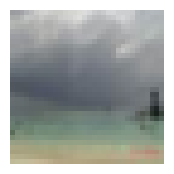

In [16]:
#generating a random number to display a random image from the dataset along with the label's number and name
#setting the figure size
rcParams['figure.figsize'] = 2,2
#generating a random number
imageId = np.random.randint(0, len(X_train))
#showing the image at that id
plt.imshow(X_train[imageId])
#setting display off for the image
plt.axis('off')
#displaying the image id
print("Image number selected : {}".format(imageId))
#displaying the shape of the image
print("Shape of image : {}".format(X_train[imageId].shape))
#displaying the category number
print("Image category number: {}".format(trainData['coarse_labels'][imageId]))
#displaying the category name
print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]][0].capitalize()))
#displaying the subcategory number
print("Image subcategory number: {}".format(trainData['fine_labels'][imageId]))
#displaying the subcategory name
print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]][0].capitalize()))

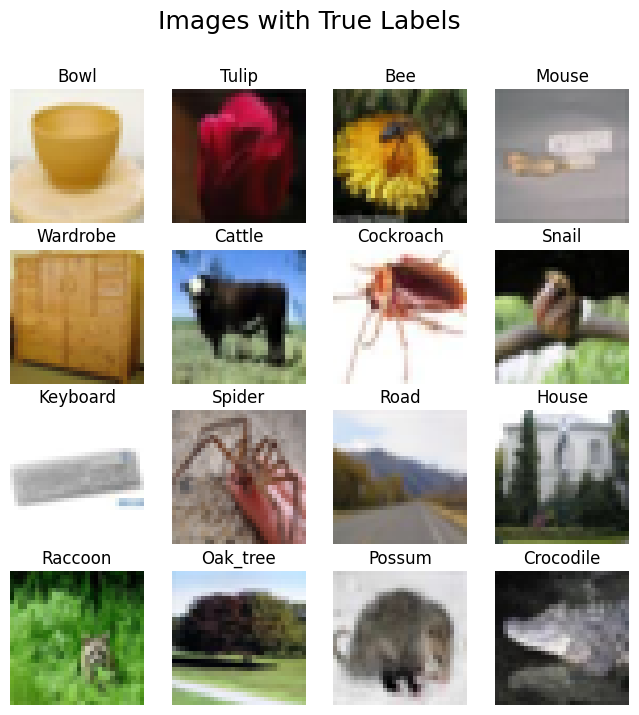

In [17]:
#16 random images to display at a time along with their true labels
#setting the figure size
rcParams['figure.figsize'] = 8,8
#number of columns and rows in which images needs to be displayed
num_row = 4
num_col = 4
#to get 4 * 4 = 16 images together
imageId = np.random.randint(0, len(X_train), num_row * num_col)
#creating subplots
fig, axes = plt.subplots(num_row, num_col)
#main title of the plot
plt.suptitle('Images with True Labels', fontsize=18)
#displaying images as subplots
for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_train[imageId[k]])
        axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())
        axes[i,j].axis('off')

In [18]:
#transforming the testing dataset
X_test = testData['data']
X_test = X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)
y_train = trainData['fine_labels']
y_test = testData['fine_labels']

In [19]:
#number of classes in the dataset
n_classes = 100
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

In [20]:
# Use stratified shuffle split to split training set into training and validation set to preserve the percentage of samples in each of the 100 classes
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

In [21]:

for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


In [22]:
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)

In [23]:
def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

In [24]:
n_classes = 100
epochs = 15
batch_size = 8

In [25]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), channels=channels, n_classes=n_classes, shuffle=True, augment=False):
        
        #initializing the configuration of the generator
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
   
    #method to be called after every epoch
    def on_epoch_end(self):
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    #return numbers of steps in an epoch using samples & batch size
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    #this method is called with the batch number as an argument to #obtain a given batch of data
    def __getitem__(self, index):
        #generate one batch of data
        #generate indexes of batch
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        
        #generate mini-batch of X
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            #generate pre-processed image
            img = self.images[ID]
            #image rescaling
            img = img.astype(np.float32)/255.
            #resizing as per new dimensions
            img = resize_img(img, self.dim)
            X[i] = img
            
        #generate mini-batch of y
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            
            #augmentation on the training dataset
            if self.augment == True:
                X = self.__augment_batch(X)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            
    #augmentation for one image
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                   albu.VerticalFlip(p=0.5),
                                   albu.GridDistortion(p=0.2),
                                   albu.ElasticTransform(p=0.2)])
        return composition(image=img)['image']
    
    #augmentation for batch of images
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
        return img_batch

In [26]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True) 
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

In [27]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True) 
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

In [28]:
efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________

In [29]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/Users/brandonl/miniforge3/envs/CV/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [30]:
model_history = model.fit_generator(train_data_generator, validation_data = valid_data_generator, callbacks = [early_stop, rlrop],verbose = 1, epochs = epochs)

#saving the trained model weights as data file in .h5 format
model.save_weights("cifar_efficientnetb0_weights.h5")

/var/folders/22/f_6vk3095hd0wjpffqpdkrdc0000gn/T/ipykernel_22715/1271447723.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_data_generator, validation_data = valid_data_generator, callbacks = [early_stop, rlrop],verbose = 1, epochs = epochs)


Epoch 1/15


2023-05-13 12:52:11.671946: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 212/5000 [>.............................] - ETA: 10:34 - loss: 4.6223 - accuracy: 0.0242

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_data_generator, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

In [ ]:
y_pred = model.predict_generator(DataGenerator(X_test, mode='predict', augment=False, shuffle=False), verbose=1)
y_pred = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")


In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target))

In [ ]:
prediction = pd.DataFrame(y_pred)
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()
